In [1]:
#installing important libraries for processing
!pip install gtfs-kit
!pip install gtfs_functions 
!pip install datashader
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 739 kB/s 
     |████████████████████████████████| 1.1 MB 21.3 MB/s 
     |████████████████████████████████| 1.0 MB 64.7 MB/s 
     |████████████████████████████████| 10.1 MB 51.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.6 MB 157 kB/s 
     |████████████████████████████████| 7.8 MB 53.9 MB/s 
  Created wheel for json2html: filename=json2html-1.3.0-py3-none-any.whl size=7609 sha256=23df6546fc9ee50ba97df4cbdb68c7dbce21616ff3943dcf7584df155bbf824e
  Stored in directory: /root/.cache/pip/wheels/34/1a/a9/0d39b9e11fc97dd947ca4df7f0f0c1f4f2e25727d3c63b7739
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681845 sha256=68857843136c2658d795743fd79f7378cdf40dc00a586c7428c80f8d7fa6a00c
  

In [2]:
from google.colab import drive
drive.mount("/content/drive")

MessageError: ignored

In [ ]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import geopy.distance
import gtfs_functions as gtfs
import pandas as pd
#DATASHADER
import datashader as ds
from datashader import transfer_functions as tr_fns
#from datashader.bokeh_ext import InteractiveImage
from functools import partial
#from datashader.bokeh_ext import InteractiveImage
import colorcet as cc
import datashader.transfer_functions as tf

In [ ]:
#unpacking the zip file with the gtfs library to DataFrames
routes, stops, stop_times, trips, shapes = gtfs.import_gtfs("/content/drive/MyDrive/gtfs.zip")

Google has a reference file that contains all the information about GTFS files: https://developers.google.com/transit/gtfs/reference
- Routes - This contains information about the whole routes (it's ID, short name that is displayed on the vehicles, and description which in this case contains the first and last stop of the route)
- Stops - Contains information about the stops in the route (It's ID, Name, and location with coordinates (With GPS coordinates that will be useful later))
- Stop_times - Is one of the most useful DataFrames. Information about the stops and the times of arrival and departure (Which can later be used to filter out needed ones)
- Trips - Almost the same as the routes DF but it contains the GPS coordinates of the whole Line (Which will later be useful for finding the lines with 1 transfer)
- Shapes - Shapes contain the Coordinates of all the routes

## Displaying the Dataframes

In [ ]:
display("Routes: ",routes,"Stops: ", stops,
        "Stop Times: ", stop_times, 
        "Trips: ", trips,"Shapes: ", shapes)

'Routes: '

,agency_id,route_id,route_short_name,route_long_name,route_type,route_desc,route_color,route_text_color,route_sort_order
0,BKK,0050,5,NaN,3,"Pasaréti tér / Rákospalota, Kossuth utca",009EE3,FFFFFF,23
1,BKK,0070,7,NaN,3,"Albertfalva vasútállomás / Újpalota, Nyírpalot...",009EE3,FFFFFF,25
2,BKK,0075,7E,NaN,3,"Blaha Lujza tér M / Újpalota, Nyírpalota út",009EE3,FFFFFF,26
3,BKK,0078,7G,NaN,3,"Cinkotai autóbuszgarázs / Újpalota, Nyírpalota út",009EE3,FFFFFF,27
4,BKK,0085,8E,NaN,3,"Kelenföld vasútállomás M / Újpalota, Nyírpalot...",009EE3,FFFFFF,28
...,...,...,...,...,...,...,...,...,...
345,HEV,H9,H9,NaN,109,Örs vezér tere / Csömör,ED6E86,FFFFFF,9
346,BKK,MP53,M3,NaN,3,Göncz Árpád városközpont M / Kálvin tér M,009EE3,FFFFFF,322
347,BKK,MP531,M3A,NaN,3,Göncz Árpád városközpont M / Nyugati pályaudvar M,009EE3,FFFFFF,323
348,BKK,MP533,M3,NaN,3,Göncz Árpád városközpont M / Kőbánya-Kispest M,009EE3,FFFFFF,321


'Stops: '

,stop_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
0,003209,Batthyány tér,09001,NaN,NaN,09001,NaN,NaN,POINT (19.03932 47.50678)
1,004903,Örs vezér tere,19795,NaN,NaN,19795,NaN,NaN,POINT (19.13719 47.50359)
2,007736,Gödöllő,19870,NaN,NaN,19870,NaN,NaN,POINT (19.35779 47.59334)
3,007817,Márta utca,NaN,NaN,NaN,NaN,2.0,160,POINT (18.92950 47.42918)
4,007877,Bíróság,NaN,NaN,NaN,NaN,1.0,-78,POINT (18.97806 47.51954)
...,...,...,...,...,...,...,...,...,...
5383,F04834,Tetra Pak,NaN,NaN,NaN,NaN,2.0,-49,POINT (18.90352 47.45783)
5384,F04835,Budaörsi lakótelep,NaN,NaN,NaN,NaN,1.0,56,POINT (18.94090 47.45569)
5385,F04836,Budaörsi lakótelep,NaN,NaN,NaN,NaN,1.0,72,POINT (18.94063 47.45564)
5386,F04837,Lejtő utca,NaN,NaN,NaN,NaN,1.0,-81,POINT (18.93061 47.45961)


'Stop Times: '

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,direction_id,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
0,C0418310,F04181,28980.0,28980.0,0,NaN,NaN,NaN,0.0,8140,...,0,Y701,Csepel-Királyerdő,NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10653 47.39789)
1,C0418310,F04526,29160.0,29160.0,1,NaN,NaN,NaN,160.0,8140,...,0,Y701,"Soroksár, Molnár-sziget",NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10869 47.39824)
2,C0418311,F04526,30600.0,30600.0,0,NaN,NaN,NaN,0.0,8140,...,1,Y702,"Soroksár, Molnár-sziget",NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10869 47.39824)
3,C0418311,F04181,30780.0,30780.0,1,NaN,NaN,NaN,160.0,8140,...,1,Y702,Csepel-Királyerdő,NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10653 47.39789)
4,C0418312,F04181,30780.0,30780.0,0,NaN,NaN,NaN,0.0,8140,...,0,Y701,Csepel-Királyerdő,NaN,NaN,NaN,NaN,2.0,NaN,POINT (19.10653 47.39789)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
810892,H8000_22,F04692,89280.0,89280.0,13,NaN,NaN,NaN,13673.0,H5,...,0,22,"Budakalász, Lenfonó",09191_F04692,NaN,NaN,NaN,NaN,NaN,POINT (19.04691 47.62169)
810893,H8000_22,F04793,89400.0,89400.0,14,NaN,NaN,NaN,14507.0,H5,...,0,22,Szentistvántelep,09209_F04793,NaN,NaN,NaN,NaN,NaN,POINT (19.04316 47.62930)
810894,H8000_22,F04690,89520.0,89580.0,15,NaN,NaN,NaN,16297.0,H5,...,0,22,Pomáz,09134_F04690,NaN,NaN,NaN,NaN,NaN,POINT (19.03203 47.64319)
810895,H8000_22,F04688,89820.0,89820.0,16,NaN,NaN,NaN,19497.0,H5,...,0,22,Pannóniatelep,09217_F04688,NaN,NaN,NaN,NaN,NaN,POINT (19.06529 47.65249)


'Trips: '

,trip_id,route_id,service_id,direction_id,shape_id
0,C0418310,8140,C04183AHPMAA-011,0,Y701
1,C0418311,8140,C04183AHPMAA-011,1,Y702
2,C0418312,8140,C04183AHPMAA-011,0,Y701
3,C0418313,8140,C04183AHPMAA-011,1,Y702
4,C0418314,8140,C04183AHPMAA-011,0,Y701
...,...,...,...,...,...
42373,H550214_1312,H9,20858,0,1312
42374,H550716_1313,H9,20858,1,1313
42375,H55125_1312,H9,20858,0,1312
42376,H55179_1313,H9,20858,1,1313


'Shapes: '

,shape_id,geometry
0,0285,"LINESTRING (19.14833 47.51965, 19.14831 47.519..."
1,0803,"LINESTRING (19.08235 47.55962, 19.08243 47.559..."
2,0976,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."
3,0977,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
4,1,"LINESTRING (19.03942 47.50667, 19.03941 47.507..."
...,...,...
1295,Z545,"LINESTRING (19.01851 47.46434, 19.01864 47.464..."
1296,Z546,"LINESTRING (18.92367 47.51776, 18.92387 47.517..."
1297,Z895,"LINESTRING (18.99852 47.49470, 18.99843 47.494..."
1298,Z962,"LINESTRING (19.04937 47.51389, 19.04941 47.513..."


There is a lot of Data with 810897 stops in a 24 hour period. Luckily we only need the 
routes that will get us to the BME I building at 8 o'clock in the morning. We also have the GPS coordinates of all the stops.

Now the first step is to find the GPS coordinates of the I building
which can be found on Google maps:

![I Building](https://github.com/BGera89/Big_Data_Homework/blob/master/I_building.png?raw=1)

Next we need to find all the stops that are in a 10 minute walk within the I building. This can differ from person to person but we used a 4km/h walking speed and calculated how many meters can you walk with that speed for 10 minutes time.

The formula for calculating distance is:
$s=v*t$ 
where $s$ is the distance walked and $t$ is the time:
- $4\frac{km}{h}=1,1\frac{m}{s}$
- $10minutes=600seconds$
- $1,1*600=660m$

So the avarage person can walk 600m-s in 10 minutes. Since Google's distance uses birds eye view we used ~600m for the distance.



In [ ]:
#variable with I building coordinates
I_building=(47.47282880598328, 19.060057869533754)
radius=(47.46980543001353, 19.05407442774218)

With the geopy library we can calculate the distance between two points so we iterated through the stops and checked wether the fell into this radius

In [ ]:
print("stops that are in a 600m radius of Building I at BME: ")
stops_600=[]
for i,k in enumerate(stops["geometry"]):
    if geopy.distance.geodesic(I_building, (k.y,k.x)).m <600.0:
        print("\t-",stops["stop_id"][i])
        stops_600.append(stops["stop_id"][i])

stops that are in a 600m radius of Building I at BME: 
	- 008280
	- 009179
	- 049597
	- 062607
	- 062608
	- 062620
	- 062621
	- 062622
	- 066451
	- 066452
	- 066453
	- 066454
	- 071262
	- F01986
	- F01988
	- F01989
	- F01990
	- F01991
	- F01992
	- F02153
	- F02155
	- F02222
	- F02224
	- F02225


In [ ]:
#now we filter stops that are in a 600m radius and reset the index
stops_I=stops[stops["stop_id"].isin(stops_600)]
stops_I.reset_index(drop=True, inplace=True)
display(stops_I)

,stop_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
0,008280,Infopark (Pázmány Péter sétány),NaN,NaN,NaN,NaN,1.0,179,POINT (19.06433 47.46924)
1,009179,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,-125,POINT (19.05892 47.47680)
2,049597,BudaPart,NaN,NaN,NaN,NaN,1.0,103,POINT (19.05716 47.46844)
3,062607,Infopark (Pázmány Péter sétány),NaN,NaN,NaN,NaN,1.0,-83,POINT (19.06299 47.46985)
4,062608,Magyar tudósok körútja,NaN,NaN,NaN,NaN,1.0,81,POINT (19.06367 47.47147)
5,062620,Egyetemváros - A38 hajóállomás,NaN,NaN,NaN,NaN,1.0,167,POINT (19.06354 47.47329)
6,062621,Egyetemváros - A38 hajóállomás,NaN,NaN,NaN,NaN,1.0,-13,POINT (19.06359 47.47373)
7,062622,Magyar tudósok körútja,NaN,NaN,NaN,NaN,1.0,168,POINT (19.06386 47.47218)
8,066451,Infopark,NaN,NaN,NaN,NaN,1.0,-85,POINT (19.05972 47.46917)
9,066452,Infopark,NaN,NaN,NaN,NaN,1.0,96,POINT (19.06050 47.46907)


In [ ]:
#Next we selected the routes with has stops within a 600m radius of the I building
shapes_within_i=[]
for j,i in enumerate(shapes["geometry"]):
    for k in stops_I["geometry"]:
        if k.x in i.coords.xy[0] and k.y in i.coords.xy[1]:
            shapes_within_i.append(shapes["shape_id"][j])
           

In [ ]:
#We filter the shapes with the selected ones
shapes_I=shapes[shapes["shape_id"].isin(shapes_within_i)]
shapes_I.reset_index(drop=True, inplace=True)
display(shapes_I)

,shape_id,geometry
0,0976,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."
1,0977,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
2,2064,"LINESTRING (19.07132 47.49604, 19.07127 47.496..."
3,AH19,"LINESTRING (19.06299 47.46985, 19.06299 47.469..."
4,B692,"LINESTRING (19.04835 47.47750, 19.04834 47.477..."
5,B693,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
6,B824,"LINESTRING (19.07134 47.49607, 19.07132 47.496..."
7,BM08,"LINESTRING (19.08126 47.50041, 19.08131 47.500..."
8,BM09,"LINESTRING (19.05793 47.46850, 19.05737 47.468..."
9,DO19,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."


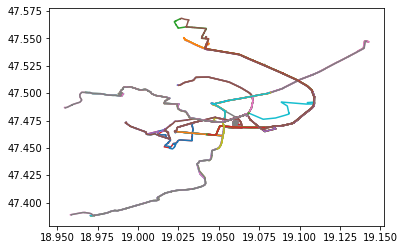

In [ ]:
#Lets see how these lines look like (The datashader one will be much better)
for i in shapes_I["geometry"]:
    x,y=i.coords.xy
    plt.plot(x,y)
    plt.scatter(I_building[1], I_building[0])
plt.show()

In [ ]:
#Now we filter in the Trips DataFrame becouse it has Route IDs and we drop the duplicates
trips_I=trips[trips["shape_id"].isin(shapes_I["shape_id"])]
trips_I.drop_duplicates(subset=["route_id"])

,trip_id,route_id,service_id,direction_id,shape_id
1446,C34268105116,3060,C34268REHHKMK-011,1,B692
1484,C34268120869,3040,C34268REHHKMK-011,0,0977
7436,C50522131,1530,C50522AHCKVA-011,1,DX77
7440,C505221645,1540,C50522AHCKVA-011,1,RM50
16250,C530791140,9180,C53079AHPMAA-021,1,VN42
18201,C537446103J,3410,C53744AHCPJ-0051,1,TL38
20469,C540151008,1335,C54015TOHCMAA-011,0,SB39
24651,C5450110,1070,C54501AHCWA-0011,0,BM09
31736,C547346553,2120,C54734AHCCsZ-031,1,QH60
31743,C547346581,2121,C54734AHCCsZ-031,0,XD69


In [ ]:
#And now we can filter the routes with the route ID so we can have the routes that has stops within a 600m radius of the I building
routes_I=routes[routes["route_id"].isin(trips_I["route_id"])]
routes_I

,agency_id,route_id,route_short_name,route_long_name,route_type,route_desc,route_color,route_text_color,route_sort_order
28,BKK,0330,33,NaN,3,"Móricz Zsigmond körtér M / Nagytétény, ipartelep",009EE3,FFFFFF,59
85,BKK,1070,107,NaN,3,BudaPart / Keleti pályaudvar M,009EE3,FFFFFF,158
114,BKK,1335,133E,NaN,3,"Újpalota, Nyírpalota út / Nagytétény, Erdélyi ...",009EE3,FFFFFF,188
135,BKK,1530,153,NaN,3,Infopark (Pázmány Péter sétány) / Gazdagréti tér,009EE3,FFFFFF,209
136,BKK,1540,154,NaN,3,BudaPart / Gazdagréti tér,009EE3,FFFFFF,210
184,BKK,2120,212,NaN,3,"Boráros tér H / Normafa, látogatóközpont",009EE3,FFFFFF,258
185,BKK,2121,212A,NaN,3,Boráros tér H / Svábhegy,009EE3,FFFFFF,259
186,BKK,2122,212B,NaN,3,"Boráros tér H / Csillebérc, KFKI",009EE3,FFFFFF,260
240,BKK,3010,1,NaN,0,Kelenföld vasútállomás M / Bécsi út / Vörösvár...,FFD800,000000,14
246,BKK,3040,4,NaN,0,Széll Kálmán tér M / Újbuda-központ M,FFD800,000000,22


In [ ]:
# Now we need filter the stops that are between 7:15 and 7:50 
# (so we still have the 10 minutes to walk to the building)
#The DataFrame stop_times has the times in second so we converted these
stop_7=stop_times[stop_times["arrival_time"]<28200]
stop_7=stop_7[stop_7["arrival_time"]>26100]
stop_7.reset_index(drop=True, inplace=True)

In [ ]:
#we have the times and we filter the stops that are in the radius
stop_7_8=stop_7[stop_7["stop_id"].isin(stops_I["stop_id"])]
stop_7_8

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,direction_id,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
654,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,1,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583)
655,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,1,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693)
672,C3426814107,F02153,27480.0,27480.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,1,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583)
673,C3426814107,F02225,27540.0,27540.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,1,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693)
766,C342682005,F01992,26160.0,26160.0,1,Széll Kálmán tér M,NaN,NaN,546.0,3040,...,1,0976,Budafoki út / Szerémi sor,NaN,NaN,NaN,NaN,1.0,55,POINT (19.05374 47.47409)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25147,C5478720734,066452,27840.0,27840.0,7,Bécsi út / Vörösvári út,NaN,NaN,3653.0,3010,...,0,N087,Infopark,NaN,NaN,NaN,NaN,1.0,96,POINT (19.06050 47.46907)
25186,C5478732343,066451,26220.0,26220.0,24,Kelenföld vasútállomás M,NaN,NaN,14504.0,3010,...,1,N088,Infopark,NaN,NaN,NaN,NaN,1.0,-85,POINT (19.05972 47.46917)
25187,C5478732343,066453,26280.0,26280.0,25,Kelenföld vasútállomás M,NaN,NaN,14970.0,3010,...,1,N088,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,-75,POINT (19.05365 47.46981)
25200,C5478732344,066454,27960.0,27960.0,6,Bécsi út / Vörösvári út,NaN,NaN,3181.0,3010,...,0,N087,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,104,POINT (19.05438 47.46965)


In [ ]:
#we created a small dictionary to be able to see the stops short names 
# (the ones that we see on the vehicles) and added them to the df
values_dict={"3060":"6", "3040":"4", "1530":"153", "1540":"154", "1335":"133E", '1070':'107', '2120':'212', '2121':"212A",
       '2122':"212B", '0330':"33", '3010':"1"}
short_names=[]
for i in stop_7_8["route_id"]:
    for k in values_dict:
        if i==k:
            short_names.append(values_dict[k])
stop_7_8["short_names"]=short_names
stop_7_8
    

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names
654,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6
655,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6
672,C3426814107,F02153,27480.0,27480.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6
673,C3426814107,F02225,27540.0,27540.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6
766,C342682005,F01992,26160.0,26160.0,1,Széll Kálmán tér M,NaN,NaN,546.0,3040,...,0976,Budafoki út / Szerémi sor,NaN,NaN,NaN,NaN,1.0,55,POINT (19.05374 47.47409),4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25147,C5478720734,066452,27840.0,27840.0,7,Bécsi út / Vörösvári út,NaN,NaN,3653.0,3010,...,N087,Infopark,NaN,NaN,NaN,NaN,1.0,96,POINT (19.06050 47.46907),1
25186,C5478732343,066451,26220.0,26220.0,24,Kelenföld vasútállomás M,NaN,NaN,14504.0,3010,...,N088,Infopark,NaN,NaN,NaN,NaN,1.0,-85,POINT (19.05972 47.46917),1
25187,C5478732343,066453,26280.0,26280.0,25,Kelenföld vasútállomás M,NaN,NaN,14970.0,3010,...,N088,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,-75,POINT (19.05365 47.46981),1
25200,C5478732344,066454,27960.0,27960.0,6,Bécsi út / Vörösvári út,NaN,NaN,3181.0,3010,...,N087,Budafoki út / Dombóvári út,NaN,NaN,NaN,NaN,1.0,104,POINT (19.05438 47.46965),1


In [ ]:
#We have the stops but we need the whole Pathways so we filter those with the trip_id
#scince it containts the whole routes
pathways_7_8=stop_times[stop_times["trip_id"].isin(stop_7_8["trip_id"])]


In [ ]:
#And we also add the short names to it
short_names=[]
for i in pathways_7_8["route_id"]:
    for k in values_dict:
        if i==k:
            short_names.append(values_dict[k])
pathways_7_8["short_names"]=short_names
pathways_7_8.reset_index(drop=True, inplace=True)
pathways_7_8.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names
0,C34268106997,009220,26400.0,26400.0,0,Széll Kálmán tér M,NaN,1,0.0,3060,...,B692,Móricz Zsigmond körtér M,NaN,NaN,NaN,NaN,1.0,NaN,POINT (19.04835 47.47750),6
1,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6
2,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6
3,C34268106997,F01374,26700.0,26700.0,3,Széll Kálmán tér M,NaN,NaN,1622.0,3060,...,B692,Boráros tér H,NaN,NaN,NaN,NaN,2.0,54,POINT (19.06670 47.48038),6
4,C34268106997,F01380,26820.0,26820.0,4,Széll Kálmán tér M,NaN,NaN,1942.0,3060,...,B692,Mester utca / Ferenc körút,NaN,NaN,NaN,NaN,1.0,14,POINT (19.06885 47.48275),6


In [ ]:
pathways_7_8["short_names"].value_counts()

1       640
133E    354
4       323
6       304
33      124
212     114
153     108
107      94
154      92
212A     71
212B     35
Name: short_names, dtype: int64

In [ ]:
pathways_7_8[pathways_7_8["trip_id"]=="C34268106997"][["departure_time", "stop_name","short_names"]]["departure_time"].apply(lambda x: abs(x-26580.0))

0      180.0
1       60.0
2        0.0
3      120.0
4      240.0
5      300.0
6      420.0
7      480.0
8      600.0
9      660.0
10     720.0
11     840.0
12     960.0
13    1080.0
14    1200.0
15    1260.0
16    1380.0
17    1500.0
18    1620.0
Name: departure_time, dtype: float64

In [ ]:
my=dict(zip(pathways_7_8["trip_id"],pathways_7_8["short_names"]))
temp=[]
res={}
for i,k in my.items():
    if k not in temp:
        temp.append(k)
        res[i]=k
res

{'C34268106997': '6',
 'C342682005': '4',
 'C50522179': '153',
 'C50522201': '154',
 'C54015135': '133E',
 'C5450110': '107',
 'C547346653': '212',
 'C547346659': '212A',
 'C547346683': '212B',
 'C5474657': '33',
 'C5478717602': '1'}

In [ ]:
list(res.keys())

['C34268106997',
 'C342682005',
 'C50522179',
 'C50522201',
 'C54015135',
 'C5450110',
 'C547346653',
 'C547346659',
 'C547346683',
 'C5474657',
 'C5478717602']

In [ ]:
pathways_one=pathways_7_8[pathways_7_8["trip_id"].isin(res.keys())]

In [ ]:
for_loop=pathways_7_8["short_names"].unique()
for_loop

array(['6', '4', '153', '154', '133E', '107', '212', '212A', '212B', '33',
       '1'], dtype=object)

In [ ]:
time_from_origin=[]
stoppyka=stops_I.drop_duplicates(subset="stop_name")["stop_name"]
for i in for_loop:
    route=pathways_one[pathways_one["short_names"]==i]
    dep_time=list(route[route["stop_name"].isin(stoppyka)]["departure_time"])[0]
    time_from_origin.append(route["departure_time"].apply(lambda x: abs(x-dep_time)))


In [ ]:
len(pathways_one)

300

In [ ]:
time_from_origin[0]
flatten_list = [i for s in time_from_origin for i in s]

In [ ]:
times=[]
for i in time_from_origin:
    for k in i:
        times.append(k)

In [ ]:
#function to make seconds to hours and minutes
def convert(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
     
    return "%d:%02d:%02d" % (hour, minutes, seconds)


In [ ]:
pathways_one["time_distance"]=times

In [ ]:
pathways_one["time_to_school"]=pathways_one["time_distance"].apply(lambda x: convert(x)+" + 10 minute walk")


In [ ]:
pathways_one

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names,time_distance,time_to_school
0,C34268106997,009220,26400.0,26400.0,0,Széll Kálmán tér M,NaN,1,0.0,3060,...,NaN,NaN,NaN,NaN,1.0,NaN,POINT (19.04835 47.47750),6,120.0,0:02:00 + 10 minute walk
1,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6,0.0,0:00:00 + 10 minute walk
2,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6,60.0,0:01:00 + 10 minute walk
3,C34268106997,F01374,26700.0,26700.0,3,Széll Kálmán tér M,NaN,NaN,1622.0,3060,...,NaN,NaN,NaN,NaN,2.0,54,POINT (19.06670 47.48038),6,180.0,0:03:00 + 10 minute walk
4,C34268106997,F01380,26820.0,26820.0,4,Széll Kálmán tér M,NaN,NaN,1942.0,3060,...,NaN,NaN,NaN,NaN,1.0,14,POINT (19.06885 47.48275),6,300.0,0:05:00 + 10 minute walk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,C5478717602,F02527,28260.0,28260.0,27,Bécsi út / Vörösvári út,NaN,NaN,15414.0,3010,...,NaN,NaN,NaN,NaN,1.0,-73,POINT (19.05887 47.53629),1,2160.0,0:36:00 + 10 minute walk
1647,C5478717602,F00626,28380.0,28380.0,28,Bécsi út / Vörösvári út,NaN,NaN,16515.0,3010,...,NaN,NaN,NaN,NaN,1.0,-73,POINT (19.04521 47.53959),1,2280.0,0:38:00 + 10 minute walk
1648,C5478717602,F00614,28500.0,28500.0,29,Bécsi út / Vörösvári út,NaN,NaN,16981.0,3010,...,NaN,NaN,NaN,NaN,1.0,-50,POINT (19.03996 47.54152),1,2400.0,0:40:00 + 10 minute walk
1649,C5478717602,F00586,28560.0,28560.0,30,Bécsi út / Vörösvári út,NaN,NaN,17680.0,3010,...,NaN,NaN,NaN,NaN,1.0,-42,POINT (19.03346 47.54596),1,2460.0,0:41:00 + 10 minute walk


In [ ]:
pathways_one["time_distance"]=pathways_one["time_distance"].apply(lambda x: 200 if x==0 else 1/x*10000)
#pathways_one["time_distance"]=pathways_one["time_distance"].apply(lambda x: 0.01 if x==0 else 1/x)

In [ ]:
#making a df just for the data we need
geometry_x=[]
geometry_y=[]
for i in pathways_one["geometry"]:
    geometry_x.append(i.x)
    geometry_y.append(i.y)
geometry_x_tuple=tuple(geometry_x)
geometry_y_tuple=tuple(geometry_y)
geometry_df=pd.DataFrame({
    'x_coor':geometry_x_tuple,
    'y_coor':geometry_y_tuple,
    'stop_name':pathways_one['stop_name'],
    "z":pathways_one["time_distance"]
})
mmt=[]

map_values1 = geometry_df[['y_coor','x_coor','z']]
data = map_values1.values.tolist()
              

In [ ]:
geometry_df["time_to_school"]=pathways_one["time_to_school"]

In [ ]:
geometry_df["vehicle"]=pathways_one["short_names"]

geometry_df

In [ ]:
geometry_df

,x_coor,y_coor,stop_name,z,time_to_school,vehicle
0,19.048349,47.477499,Móricz Zsigmond körtér M,83.333333,0:02:00 + 10 minute walk,6
1,19.054107,47.475827,Budafoki út / Karinthy Frigyes út,200.000000,0:00:00 + 10 minute walk,6
2,19.059586,47.476933,"Petőfi híd, budai hídfő",166.666667,0:01:00 + 10 minute walk,6
3,19.066698,47.480376,Boráros tér H,55.555556,0:03:00 + 10 minute walk,6
4,19.068848,47.482751,Mester utca / Ferenc körút,33.333333,0:05:00 + 10 minute walk,6
...,...,...,...,...,...,...
1646,19.058868,47.536294,Népfürdő utca / Árpád híd,4.629630,0:36:00 + 10 minute walk,1
1647,19.045207,47.539593,Szentlélek tér H,4.385965,0:38:00 + 10 minute walk,1
1648,19.039960,47.541517,Flórián tér,4.166667,0:40:00 + 10 minute walk,1
1649,19.033456,47.545957,Óbudai rendelőintézet,4.065041,0:41:00 + 10 minute walk,1



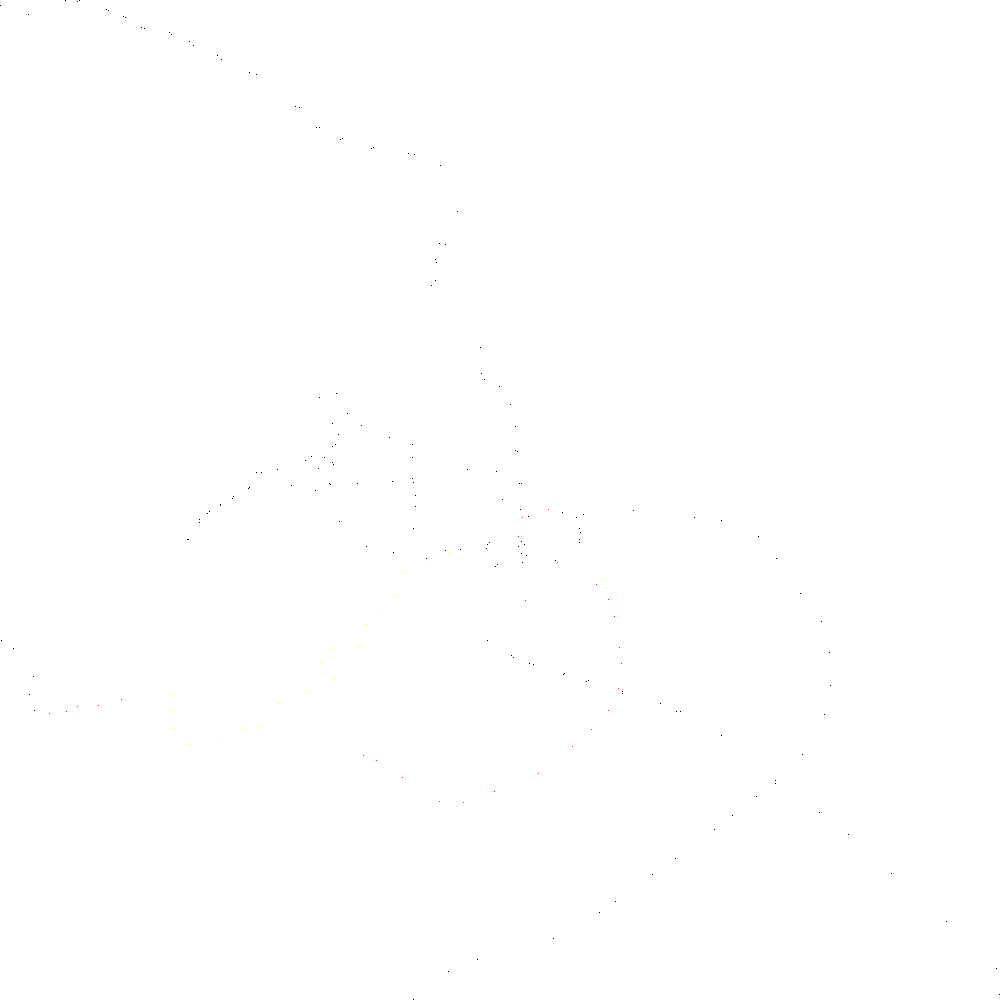

In [ ]:
#import pandas as pd
#!pip install plotly
import plotly.express as px
dff = geometry_df.query('y_coor < 47.548766').query('y_coor > 47.387982').query('x_coor > 18.954419').query('x_coor < 19.142015')
#bme_i = 47.47277215114886, 19.060034103922074
import plotly
#datashader steps
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(dff, x='x_coor', y='y_coor')
# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
coords_lat, coords_lon = agg.coords['y_coor'].values, agg.coords['x_coor'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

from colorcet import fire
import plotly.graph_objects as go
import datashader.transfer_functions as tf
img = tf.shade(agg, cmap=fire)[::-1].to_pil()

import plotly.express as px
# Trick to create rapidly a figure with mapbox axes
#fig = px.density_mapbox(geometry_df, lat=geometry_df.y_coor, lon= geometry_df.x_coor,zoom=12, hover_name='stop_name', 
#                        hover_data=["x_coor", "y_coor"], radius=5, labels={'get_on':'get_on', 'time_to_school':'time_to_school'})
fig = px.density_mapbox(geometry_df, lat = geometry_df.y_coor, lon = geometry_df.x_coor, z=geometry_df.z,
                        radius=20,
                        hover_name="stop_name",
                        hover_data=["x_coor","y_coor","time_to_school","vehicle"],
                        center = dict(lat = 47.47277215114886, lon = 19.060034103922074),
                        zoom = 12,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        )


#point to BME
fig.add_trace(go.Scattermapbox(
        lat=[47.47277215114886],
        lon=[19.060034103922074],
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(0, 144, 144)',
            opacity=0.7
        ),
        text=["BME I Epulet"],
    ) )
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

In [ ]:
geometry_df.reset_index(inplace=True)

In [ ]:
import folium
from folium.plugins import HeatMap


In [ ]:
map_values1 = geometry_df[['y_coor','x_coor','z']]
data = map_values1.values.tolist()

In [ ]:
I_building=(47.47282880598328, 19.060057869533754)
#Define coordinates of where we want to center our map
boulder_coords = [I_building[0], I_building[1]]



#Create the map
my_map = folium.Map(location = boulder_coords, zoom_start = 13,)
for i in range(len(geometry_df)):
    folium.Circle((geometry_df["y_coor"][i], geometry_df["x_coor"][i]), fill_color = 200,
                            radius = 100+geometry_df["z"][i], popup=geometry_df["stop_name"][i]).add_to(my_map)


hm = HeatMap(data,gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
                min_opacity=0.4, 
                max_opacity=0.9, 
                radius=25,
                use_local_extrema=False).add_to(my_map)
#Display the map
my_map

In [ ]:
shapes_I

In [ ]:
import shapely

In [ ]:
lats = []
lons = []
names = []

for feature, name in zip(shapes_I.geometry, shapes_I["shape_id"]):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)


In [ ]:
fig = px.line_mapbox(lat=lats, lon=lons, hover_name=names)

fig.update_layout(mapbox_style="carto-darkmatter",
                  mapbox_zoom=10,
                  
                  margin={"r":0,"t":0,"l":0,"b":0})

In [ ]:
#Create a list that stores the linestrings of pathways that intercept the stops in the 
# previus DataFrame 
points_with_linestr=[]
points=[]
for i in shapes["geometry"]:
    for k in pathways_7_8["geometry"]:
        if (i.distance(k)<1e-8) and i not in points_with_linestr:
            x,y=k.xy
            points.append(k)
            #x,y=i.coords.xy
            #points_intercept.append((tuple(x), tuple(y)))
            points_with_linestr.append(i)

In [ ]:
stops_intercept_rendes=stop_times[stop_times["geometry"].isin(points)]
stops_intercept_rendes

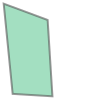

In [ ]:
from shapely import geometry
egy=(47.44686676822845, 18.965463583916762)
ketto=(47.5655472483503, 18.958243438356227)
harom=(47.55125478363083, 19.185918695031727)
negy=(47.42016738759728, 19.234534341805986)
point_list=[egy,ketto,harom,negy]
p = geometry.Polygon(point_list)
p

In [ ]:
import folium
m = folium.Map(tiles='openstreetmap')
m.fit_bounds([[egy[0], egy[1]], [ketto[0], ketto[1]]])
folium.GeoJson(poly).add_to(m)
m

In [ ]:
!pip install qgis-plugin-ci

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 10.0 MB/s 
     |████████████████████████████████| 291 kB 17.1 MB/s 
     |████████████████████████████████| 8.4 MB 18.3 MB/s 
     |████████████████████████████████| 662 kB 62.0 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 856 kB 36.3 MB/s 
     |████████████████████████████████| 59.9 MB 1.2 MB/s 
     |████████████████████████████████| 361 kB 46.2 MB/s 
  Created wheel for qgis-plugin-ci: filename=qgis_plugin_ci-2.5.2-py3-none-any.whl size=34381 sha256=b85cb3121a596e3a721cc144d1b2aaa860424700e396de312dce28602ddc9db9
  Stored in directory: /root/.cache/pip/wheels/e8/5a/69/7b85945ee0174a07d7b562687f4170a4ebab4e0dc7575b76d7
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6781 sha256=189753a16a5cd72e9935b52c502f3a2d4821dd518c9d935fd526ef02ac258a

In [ ]:
from qgis.core import *
from qgis.PyQt.QtCore import QVariant

def cut_polygon_into_windows(p, window_height, window_width):

    crs = p.crs().toWkt()
    extent = p.extent()
    (xmin, xmax, ymin, ymax) = (extent.xMinimum(), extent.xMaximum(), extent.yMinimum(), extent.yMaximum())

    # Create the grid layer
    vector_grid = QgsVectorLayer('Polygon?crs='+ crs, 'vector_grid' , 'memory')
    prov = vector_grid.dataProvider()

    # Create the grid layer
    output = QgsVectorLayer('Polygon?crs='+ crs, 'output' , 'memory')
    outprov = output.dataProvider()

    # Add ids and coordinates fields
    fields = QgsFields()
    fields.append(QgsField('ID', QVariant.Int, '', 10, 0))
    outprov.addAttributes(fields)

    # Generate the features for the vector grid
    id = 0
    y = ymax
    while y >= ymin:
        x = xmin
        while x <= xmax:
            point1 = QgsPoint(x, y)
            point2 = QgsPoint(x + window_width, y)
            point3 = QgsPoint(x + window_width, y - window_height)
            point4 = QgsPoint(x, y - window_height)
            vertices = [point1, point2, point3, point4] # Vertices of the polygon for the current id
            inAttr = [id]
            feat = QgsFeature()
            feat.setGeometry(QgsGeometry().fromPolygon([vertices])) # Set geometry for the current id
            feat.setAttributes(inAttr) # Set attributes for the current id
            prov.addFeatures([feat])
            x = x + window_width
            id += 1
        y = y - window_height

    index = QgsSpatialIndex() # Spatial index
    for ft in vector_grid.getFeatures():
        index.insertFeature(ft)

    for feat in p.getFeatures():
        geom = feat.geometry()
        idsList = index.intersects(geom.boundingBox())
        for gridfeat in vector_grid.getFeatures(QgsFeatureRequest().setFilterFids(idsList)):
            tmp_geom = QgsGeometry(gridfeat.geometry())
            tmp_attrs = gridfeat.attributes()
            if geom.intersects(tmp_geom):
                int = QgsGeometry(geom.intersection(tmp_geom))
                outfeat = QgsFeature()
                outfeat.setGeometry(int)
                outfeat.setAttributes(tmp_attrs)
                outprov.addFeatures([outfeat])

    output.updateFields()

    return output
window_width = 3
window_height = 3

# Run the function
output = cut_polygon_into_windows(p, window_height, window_width)

# Add the layer to the Layers panel
QgsMapLayerRegistry.instance().addMapLayers([output])


ModuleNotFoundError: ignored

In [ ]:
# now we filter the shapes with these strings so it only contains the routes 
# that intercept the stops
shapes_intercept=shapes[shapes["geometry"].isin(points_with_linestr)]
shapes_intercept

,shape_id,geometry
2,0976,"LINESTRING (19.04686 47.47404, 19.04688 47.474..."
3,0977,"LINESTRING (19.02519 47.50723, 19.02518 47.507..."
77,2064,"LINESTRING (19.07132 47.49604, 19.07127 47.496..."
117,7404,"LINESTRING (19.09142 47.47069, 19.09139 47.470..."
126,A776,"LINESTRING (19.00526 47.43212, 19.00518 47.432..."
...,...,...
1292,Z255,"LINESTRING (18.94023 47.45575, 18.94028 47.455..."
1293,Z262,"LINESTRING (19.01378 47.40563, 19.01375 47.405..."
1295,Z545,"LINESTRING (19.01851 47.46434, 19.01864 47.464..."
1296,Z546,"LINESTRING (18.92367 47.51776, 18.92387 47.517..."


In [ ]:
#Now find the trips and from that the stops
trips_intercept=trips[trips["shape_id"].isin(shapes_intercept["shape_id"])]
stops_intercept=stop_times[stop_times["trip_id"].isin(trips_intercept["trip_id"])]
stops_intercept

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,direction_id,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry
15107,C34268105116,009220,25200.0,25200.0,0,Széll Kálmán tér M,NaN,1,0.0,3060,...,1,B692,Móricz Zsigmond körtér M,NaN,NaN,NaN,NaN,1.0,NaN,POINT (19.04835 47.47750)
15108,C34268105116,F02153,25320.0,25320.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,1,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583)
15109,C34268105116,F02225,25380.0,25380.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,1,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693)
15110,C34268105116,F01374,25500.0,25500.0,3,Széll Kálmán tér M,NaN,NaN,1622.0,3060,...,1,B692,Boráros tér H,NaN,NaN,NaN,NaN,2.0,54,POINT (19.06670 47.48038)
15111,C34268105116,F01380,25620.0,25620.0,4,Széll Kálmán tér M,NaN,NaN,1942.0,3060,...,1,B692,Mester utca / Ferenc körút,NaN,NaN,NaN,NaN,1.0,14,POINT (19.06885 47.48275)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799978,C56119974,F02980,32580.0,32580.0,8,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,4694.0,3014,...,0,TI52,Ajtósi Dürer sor,NaN,NaN,NaN,NaN,1.0,-46,POINT (19.09576 47.51381)
799979,C56119974,F02924,32700.0,32700.0,9,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,5169.0,3014,...,0,TI52,"Erzsébet királyné útja, aluljáró",NaN,NaN,NaN,NaN,1.0,-49,POINT (19.09139 47.51681)
799980,C56119974,F02893,32760.0,32760.0,10,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,5527.0,3014,...,0,TI52,Kacsóh Pongrác út,NaN,NaN,NaN,NaN,1.0,-46,POINT (19.08811 47.51906)
799981,C56119974,F02631,32880.0,32880.0,11,KOCSISZÍNBE Lehel u. / Róbert K. krt.,NaN,NaN,6271.0,3014,...,0,TI52,Vágány utca / Róbert Károly körút,NaN,NaN,NaN,NaN,1.0,-46,POINT (19.08099 47.52362)


In [ ]:
#and we filter for time from 7:15-7:50 like before
stops_intercept_7_8=stops_intercept[stops_intercept["arrival_time"]<28200]
stops_intercept_7_8=stops_intercept_7_8[stops_intercept_7_8["arrival_time"]>26100]

In [ ]:
#and add the short names
values_dict=dict(zip(routes["route_id"], routes["route_short_name"]))
short_names=[]
for i in stops_intercept_7_8["route_id"]:
    for k in values_dict:
        if i==k:
            short_names.append(values_dict[k])
stops_intercept_7_8["short_names"]=short_names
stops_intercept_7_8

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names
15118,C34268105116,F01082,26220.0,26220.0,11,Széll Kálmán tér M,NaN,NaN,4773.0,3060,...,B692,Oktogon M,NaN,NaN,NaN,NaN,1.0,-43,POINT (19.06241 47.50594),6
15119,C34268105116,F00933,26340.0,26340.0,12,Széll Kálmán tér M,NaN,NaN,5454.0,3060,...,B692,Nyugati pályaudvar M,NaN,NaN,NaN,NaN,1.0,-56,POINT (19.05617 47.51027),6
15120,C34268105116,F00925,26460.0,26460.0,13,Széll Kálmán tér M,NaN,NaN,6141.0,3060,...,B692,Jászai Mari tér,NaN,NaN,NaN,NaN,1.0,-67,POINT (19.04818 47.51310),6
15121,C34268105116,F00141,26580.0,26580.0,14,Széll Kálmán tér M,NaN,NaN,6621.0,3060,...,B692,Margitsziget / Margit híd,NaN,NaN,NaN,NaN,1.0,-93,POINT (19.04252 47.51472),6
15122,C34268105116,F00192,26640.0,26640.0,15,Széll Kálmán tér M,NaN,NaN,6953.0,3060,...,B692,"Margit híd, budai hídfő H",NaN,NaN,NaN,NaN,1.0,-92,POINT (19.03819 47.51462),6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799486,C5611982,008262,26280.0,26280.0,16,Népliget M,NaN,NaN,9379.0,3014,...,TC22,Hidegkuti Nándor Stadion,NaN,NaN,NaN,NaN,1.0,-180,POINT (19.10891 47.49069),1M
799487,C5611982,008148,26400.0,26400.0,17,Népliget M,NaN,NaN,9955.0,3014,...,TC22,Kőbányai út / Könyves Kálmán körút,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10708 47.48574),1M
799488,C5611982,008146,26460.0,26460.0,18,Népliget M,NaN,NaN,10529.0,3014,...,TC22,Vajda Péter utca,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10317 47.48139),1M
799489,C5611982,F01286,26580.0,26580.0,19,Népliget M,1.0,NaN,11223.0,3014,...,TC22,Népliget M,NaN,NaN,NaN,NaN,1.0,-150,POINT (19.09891 47.47588),1M


In [ ]:
pathways_7_8["short_names"].value_counts()

1       640
133E    354
4       323
6       304
33      124
212     114
153     108
107      94
154      92
212A     71
212B     35
Name: short_names, dtype: int64

In [ ]:
#and we save this DF too
stops_intercept_7_8.to_csv("stops_that_intercept_7_8.csv")

In [ ]:
distances=[]
for i in stops_intercept_7_8["geometry"]:
    distances.append(geopy.distance.geodesic(I_building, (i.y,i.x)).m)

In [ ]:
stops_intercept_7_8["distance_I"]=distances

In [ ]:
stops_intercept_7_8

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names,distance_I
15118,C34268105116,F01082,26220.0,26220.0,11,Széll Kálmán tér M,NaN,NaN,4773.0,3060,...,Oktogon M,NaN,NaN,NaN,NaN,1.0,-43,POINT (19.06241 47.50594),6,3685.454529
15119,C34268105116,F00933,26340.0,26340.0,12,Széll Kálmán tér M,NaN,NaN,5454.0,3060,...,Nyugati pályaudvar M,NaN,NaN,NaN,NaN,1.0,-56,POINT (19.05617 47.51027),6,4173.479026
15120,C34268105116,F00925,26460.0,26460.0,13,Széll Kálmán tér M,NaN,NaN,6141.0,3060,...,Jászai Mari tér,NaN,NaN,NaN,NaN,1.0,-67,POINT (19.04818 47.51310),6,4565.889257
15121,C34268105116,F00141,26580.0,26580.0,14,Széll Kálmán tér M,NaN,NaN,6621.0,3060,...,Margitsziget / Margit híd,NaN,NaN,NaN,NaN,1.0,-93,POINT (19.04252 47.51472),6,4840.997554
15122,C34268105116,F00192,26640.0,26640.0,15,Széll Kálmán tér M,NaN,NaN,6953.0,3060,...,"Margit híd, budai hídfő H",NaN,NaN,NaN,NaN,1.0,-92,POINT (19.03819 47.51462),6,4929.618086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799486,C5611982,008262,26280.0,26280.0,16,Népliget M,NaN,NaN,9379.0,3014,...,Hidegkuti Nándor Stadion,NaN,NaN,NaN,NaN,1.0,-180,POINT (19.10891 47.49069),1M,4183.340634
799487,C5611982,008148,26400.0,26400.0,17,Népliget M,NaN,NaN,9955.0,3014,...,Kőbányai út / Könyves Kálmán körút,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10708 47.48574),1M,3823.744098
799488,C5611982,008146,26460.0,26460.0,18,Népliget M,NaN,NaN,10529.0,3014,...,Vajda Péter utca,NaN,NaN,NaN,NaN,1.0,-152,POINT (19.10317 47.48139),1M,3386.421997
799489,C5611982,F01286,26580.0,26580.0,19,Népliget M,1.0,NaN,11223.0,3014,...,Népliget M,NaN,NaN,NaN,NaN,1.0,-150,POINT (19.09891 47.47588),1M,2948.027184


In [ ]:
stops_rendes=stops_intercept_7_8[stops_intercept_7_8["geometry"].isin(points)]

In [ ]:
stops_rendes["stop_name"].unique()

array(['Mechwart liget', 'Móricz Zsigmond körtér M',
       'Petőfi híd, budai hídfő', 'Újbuda-központ M',
       'Margit híd, budai hídfő H', 'Széna tér', 'Széll Kálmán tér M',
       'Kosztolányi Dezső tér', 'Lépcsős utca', 'Jókai Mór utca',
       'Őrmezei út', 'Kelenföld vasútállomás M',
       'Leányka utcai lakótelep', 'Városház tér',
       'Zelk Zoltán út (Menyecske utca)', 'Gazdagréti út',
       'Jégvirág utca', 'Dayka Gábor utca', 'Gazdagréti tér',
       'Nagyszeben út', 'Március 15. tér', 'Astoria M', 'Sasadi út',
       'Tisza István tér', 'Zugló vasútállomás', 'Keleti pályaudvar M',
       'Blaha Lujza tér M', 'Uránia', 'Újpalota, Nyírpalota út',
       'Vásárcsarnok', 'Molnár Viktor utca', 'Bosnyák tér', 'Fő tér',
       'Bikás park M', 'Karolina út', 'Duránci utca',
       'Infopark (Pázmány Péter sétány)', 'Andor utca / Tétényi út',
       'Egyetemváros - A38 hajóállomás', 'Budafoki út / Dombóvári út',
       'Kiss János altábornagy utca',
       'Budatétény vasútállo

In [ ]:
my=dict(zip(stops_intercept_7_8["trip_id"],stops_intercept_7_8["short_names"]))
temp=[]
res={}
for i,k in my.items():
    if k not in temp:
        temp.append(k)
        res[i]=k
res

{'C34268105116': '6',
 'C342681730': '4',
 'C3635065': '49',
 'C3800224': '138',
 'C45939101': '19',
 'C46206404': '250',
 'C46206410': '250B',
 'C46470428': '141',
 'C47110102': '139',
 'C48289101': '8E',
 'C4951840': '58',
 'C5048315': '251A',
 'C5052049': '53',
 'C50522133': '153',
 'C50522192': '154',
 'C5104028': '296',
 'C5104047': '96',
 'C513071031': '59B',
 'C514521399': '114',
 'C51452174': '213',
 'C51452202': '214',
 'C51579111': '101B',
 'C51579116': '101E',
 'C51744101': '150',
 'C5239418': '287',
 'C5241641': '13',
 'C5241647': '113A',
 'C5265328': '240',
 'C52683115': '196',
 'C52683128': '196A',
 'C529511001': '88A',
 'C529511006': '40',
 'C529511011': '40B',
 'C52951118': '88',
 'C529512660': '40E',
 'C5377220': '277',
 'C53823221J': '2',
 'C539901128': '272',
 'C5399011948': '172',
 'C539902658': '173',
 'C54015135': '133E',
 'C5411439': '188E',
 'C54153144': '158',
 'C541541279': '191',
 'C544891275': '291',
 'C544891280': '91',
 'C5450110': '107',
 'C54505176': '20

In [ ]:
list(res.keys())

['C34268105116',
 'C342681730',
 'C3635065',
 'C3800224',
 'C45939101',
 'C46206404',
 'C46206410',
 'C46470428',
 'C47110102',
 'C48289101',
 'C4951840',
 'C5048315',
 'C5052049',
 'C50522133',
 'C50522192',
 'C5104028',
 'C5104047',
 'C513071031',
 'C514521399',
 'C51452174',
 'C51452202',
 'C51579111',
 'C51579116',
 'C51744101',
 'C5239418',
 'C5241641',
 'C5241647',
 'C5265328',
 'C52683115',
 'C52683128',
 'C529511001',
 'C529511006',
 'C529511011',
 'C52951118',
 'C529512660',
 'C5377220',
 'C53823221J',
 'C539901128',
 'C5399011948',
 'C539902658',
 'C54015135',
 'C5411439',
 'C54153144',
 'C541541279',
 'C544891275',
 'C544891280',
 'C5450110',
 'C54505176',
 'C54530103',
 'C5453085',
 'C5458629',
 'C5458637',
 'C54589105',
 'C54589129',
 'C54589153',
 'C54621124',
 'C54621130',
 'C5465922',
 'C547346611',
 'C547346617',
 'C547346629',
 'C5474657',
 'C5478717591',
 'C54854119',
 'C5486312',
 'C54869147',
 'C5489637',
 'C54943114',
 'C5510746',
 'C552751412',
 'C5531540',
 'C55

In [ ]:
pathways_7_8

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,route_id,...,shape_id,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names
0,C34268106997,009220,26400.0,26400.0,0,Széll Kálmán tér M,NaN,1,0.0,3060,...,B692,Móricz Zsigmond körtér M,NaN,NaN,NaN,NaN,1.0,NaN,POINT (19.04835 47.47750),6
1,C34268106997,F02153,26520.0,26520.0,1,Széll Kálmán tér M,NaN,NaN,477.0,3060,...,B692,Budafoki út / Karinthy Frigyes út,NaN,NaN,NaN,NaN,1.0,114,POINT (19.05411 47.47583),6
2,C34268106997,F02225,26580.0,26580.0,2,Széll Kálmán tér M,NaN,NaN,960.0,3060,...,B692,"Petőfi híd, budai hídfő",NaN,NaN,NaN,NaN,1.0,54,POINT (19.05959 47.47693),6
3,C34268106997,F01374,26700.0,26700.0,3,Széll Kálmán tér M,NaN,NaN,1622.0,3060,...,B692,Boráros tér H,NaN,NaN,NaN,NaN,2.0,54,POINT (19.06670 47.48038),6
4,C34268106997,F01380,26820.0,26820.0,4,Széll Kálmán tér M,NaN,NaN,1942.0,3060,...,B692,Mester utca / Ferenc körút,NaN,NaN,NaN,NaN,1.0,14,POINT (19.06885 47.48275),6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2254,C5478732344,F02527,30120.0,30120.0,27,Bécsi út / Vörösvári út,NaN,NaN,15414.0,3010,...,N087,Népfürdő utca / Árpád híd,NaN,NaN,NaN,NaN,1.0,-73,POINT (19.05887 47.53629),1
2255,C5478732344,F00626,30240.0,30240.0,28,Bécsi út / Vörösvári út,NaN,NaN,16515.0,3010,...,N087,Szentlélek tér H,NaN,NaN,NaN,NaN,1.0,-73,POINT (19.04521 47.53959),1
2256,C5478732344,F00614,30360.0,30360.0,29,Bécsi út / Vörösvári út,NaN,NaN,16981.0,3010,...,N087,Flórián tér,NaN,NaN,NaN,NaN,1.0,-50,POINT (19.03996 47.54152),1
2257,C5478732344,F00586,30420.0,30420.0,30,Bécsi út / Vörösvári út,NaN,NaN,17680.0,3010,...,N087,Óbudai rendelőintézet,NaN,NaN,NaN,NaN,1.0,-42,POINT (19.03346 47.54596),1


In [ ]:
intercept_one=stops_intercept_7_8[stops_intercept_7_8["trip_id"].isin(res.keys())]
intercept_one.reset_index(inplace=True)
intercept_one=intercept_one[intercept_one["trip_id"]!="C4951840"]

In [ ]:
for_loop=intercept_one["short_names"].unique()
for_loop

array(['6', '4', '49', '138', '19', '250', '250B', '141', '139', '8E',
       '251A', '53', '153', '154', '296', '96', '114', '213', '214',
       '101B', '101E', '150', '13', '113A', '196', '88A', '40', '40B',
       '88', '40E', '2', '272', '172', '173', '133E', '188E', '158',
       '191', '91', '107', '20E', '46', '187', '110', '110E', '105',
       '130', '212A', '212', '33', '1', '51A', '108E', '7', '17', '7E',
       '5', '30A', '140A', '140', '221', '21A', '21', '1M'], dtype=object)

In [ ]:
pathways_one

In [ ]:
stoppyka

In [ ]:
time_from_origin=[]
stoppyka=stops_rendes["stop_name"].unique()
for i in for_loop:
    route=intercept_one[intercept_one["short_names"]==i]
    dep_time=list(route[route["stop_name"].isin(stoppyka)]["departure_time"])
    time_from_origin.append(route["departure_time"].apply(lambda x: abs(x-dep_time)))


In [ ]:
time_from_origin

[0    420.0
 1    300.0
 2    180.0
 3     60.0
 4      0.0
 5    120.0
 6    240.0
 7    360.0
 Name: departure_time, dtype: float64, 8    0.0
 Name: departure_time, dtype: float64, 9       0.0
 10     60.0
 11    180.0
 12    300.0
 Name: departure_time, dtype: float64, 13    420.0
 14    240.0
 15    120.0
 16      0.0
 17     60.0
 Name: departure_time, dtype: float64, 18       0.0
 19      60.0
 20     120.0
 21     180.0
 22     300.0
 23     420.0
 24     540.0
 25     600.0
 26     660.0
 27     780.0
 28     900.0
 29    1140.0
 30    1140.0
 31    1260.0
 32    1380.0
 33    1440.0
 Name: departure_time, dtype: float64, 34    540.0
 35    480.0
 36    420.0
 37    360.0
 38    300.0
 39    240.0
 40    180.0
 41      0.0
 42     60.0
 43    120.0
 44    180.0
 Name: departure_time, dtype: float64, 45     0.0
 46    60.0
 Name: departure_time, dtype: float64, 47    840.0
 48    780.0
 49    720.0
 50    660.0
 51    600.0
 52    360.0
 53      0.0
 Name: departure_time, dtype:

In [ ]:
route

,index,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,...,stop_name,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names,distance_I
746,787944,C559858827,F02455,26160.0,26160.0,19,"Csillebérc, KFKI",NaN,NaN,7885.0,...,Sötétvágás utca,NaN,NaN,NaN,NaN,2.0,164,POINT (18.96466 47.49486),221,7595.535565
747,787945,C559858827,F02273,26160.0,26160.0,20,"Csillebérc, KFKI",NaN,NaN,8532.0,...,Magas út,NaN,NaN,NaN,NaN,2.0,-123,POINT (18.96098 47.49041),221,7718.973000
748,787946,C559858827,F02270,26220.0,26220.0,21,"Csillebérc, KFKI",NaN,NaN,8753.0,...,KFKI étterem,NaN,NaN,NaN,NaN,2.0,-137,POINT (18.95883 47.48916),221,7842.326381
749,787947,C559858827,F02269,26280.0,26280.0,22,"Csillebérc, KFKI",1.0,NaN,9206.0,...,"Csillebérc, KFKI",NaN,NaN,NaN,NaN,1.0,-63,POINT (18.95442 47.48686),221,8113.634488


In [ ]:
intercept_one=intercept_one[intercept_one["trip_id"]!="C559858827"]
for_loop=intercept_one["short_names"].unique()
for_loop

array(['6', '4', '49', '138', '19', '250', '250B', '141', '139', '8E',
       '251A', '53', '153', '154', '296', '96', '114', '213', '214',
       '101B', '101E', '150', '13', '113A', '196', '88A', '40', '40B',
       '88', '40E', '2', '272', '172', '173', '133E', '188E', '158',
       '191', '91', '107', '20E', '46', '187', '110', '110E', '105',
       '130', '212A', '212', '33', '1', '51A', '108E', '7', '17', '7E',
       '5', '140A', '21A', '21', '1M'], dtype=object)

In [ ]:
times=[]
for i in time_from_origin:
    for k in i:
        times.append(k)

In [ ]:
intercept_one["times"]=times

In [ ]:
intercept_one

,index,trip_id,stop_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,...,stop_code,location_type,location_sub_type,parent_station,wheelchair_boarding,stop_direction,geometry,short_names,distance_I,times
0,15118,C34268105116,F01082,26220.0,26220.0,11,Széll Kálmán tér M,NaN,NaN,4773.0,...,NaN,NaN,NaN,NaN,1.0,-43,POINT (19.06241 47.50594),6,3685.454529,420.0
1,15119,C34268105116,F00933,26340.0,26340.0,12,Széll Kálmán tér M,NaN,NaN,5454.0,...,NaN,NaN,NaN,NaN,1.0,-56,POINT (19.05617 47.51027),6,4173.479026,300.0
2,15120,C34268105116,F00925,26460.0,26460.0,13,Széll Kálmán tér M,NaN,NaN,6141.0,...,NaN,NaN,NaN,NaN,1.0,-67,POINT (19.04818 47.51310),6,4565.889257,180.0
3,15121,C34268105116,F00141,26580.0,26580.0,14,Széll Kálmán tér M,NaN,NaN,6621.0,...,NaN,NaN,NaN,NaN,1.0,-93,POINT (19.04252 47.51472),6,4840.997554,60.0
4,15122,C34268105116,F00192,26640.0,26640.0,15,Széll Kálmán tér M,NaN,NaN,6953.0,...,NaN,NaN,NaN,NaN,1.0,-92,POINT (19.03819 47.51462),6,4929.618086,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,788115,C559858852,110321,27240.0,27240.0,16,Normafa,1.0,NaN,6999.0,...,NaN,NaN,NaN,NaN,1.0,-76,POINT (18.96744 47.50074),21,7638.528335,780.0
775,797542,C5611917,F00626,26160.0,26160.0,16,Bécsi út / Vörösvári út,NaN,NaN,9595.0,...,NaN,NaN,NaN,NaN,1.0,-73,POINT (19.04521 47.53959),1M,7506.729210,180.0
776,797543,C5611917,F00614,26280.0,26280.0,17,Bécsi út / Vörösvári út,NaN,NaN,10061.0,...,NaN,NaN,NaN,NaN,1.0,-50,POINT (19.03996 47.54152),1M,7785.440229,60.0
777,797544,C5611917,F00586,26340.0,26340.0,18,Bécsi út / Vörösvári út,NaN,NaN,10760.0,...,NaN,NaN,NaN,NaN,1.0,-42,POINT (19.03346 47.54596),1M,8373.762806,0.0


In [ ]:
#making a df just for the data we need
geometry_x=[]
geometry_y=[]
for i in intercept_one["geometry"]:
    geometry_x.append(i.x)
    geometry_y.append(i.y)
geometry_x_tuple=tuple(geometry_x)
geometry_y_tuple=tuple(geometry_y)
geometry_df=pd.DataFrame({
    'x_coor':geometry_x_tuple,
    'y_coor':geometry_y_tuple,
    'stop_name':intercept_one['stop_name'],
    "z":intercept_one["times"]
})
mmt=[]

map_values1 = geometry_df[['y_coor','x_coor','z']]
data = map_values1.values.tolist()
              

In [ ]:
geometry_df["time_to_school"]=intercept_one["times"]

In [ ]:
geometry_df["vehicle"]=intercept_one["short_names"]

geometry_df

In [ ]:
geometry_df

,x_coor,y_coor,stop_name,z,time_to_school,vehicle
0,19.048349,47.477499,Móricz Zsigmond körtér M,83.333333,0:02:00 + 10 minute walk,6
1,19.054107,47.475827,Budafoki út / Karinthy Frigyes út,200.000000,0:00:00 + 10 minute walk,6
2,19.059586,47.476933,"Petőfi híd, budai hídfő",166.666667,0:01:00 + 10 minute walk,6
3,19.066698,47.480376,Boráros tér H,55.555556,0:03:00 + 10 minute walk,6
4,19.068848,47.482751,Mester utca / Ferenc körút,33.333333,0:05:00 + 10 minute walk,6
...,...,...,...,...,...,...
1646,19.058868,47.536294,Népfürdő utca / Árpád híd,4.629630,0:36:00 + 10 minute walk,1
1647,19.045207,47.539593,Szentlélek tér H,4.385965,0:38:00 + 10 minute walk,1
1648,19.039960,47.541517,Flórián tér,4.166667,0:40:00 + 10 minute walk,1
1649,19.033456,47.545957,Óbudai rendelőintézet,4.065041,0:41:00 + 10 minute walk,1



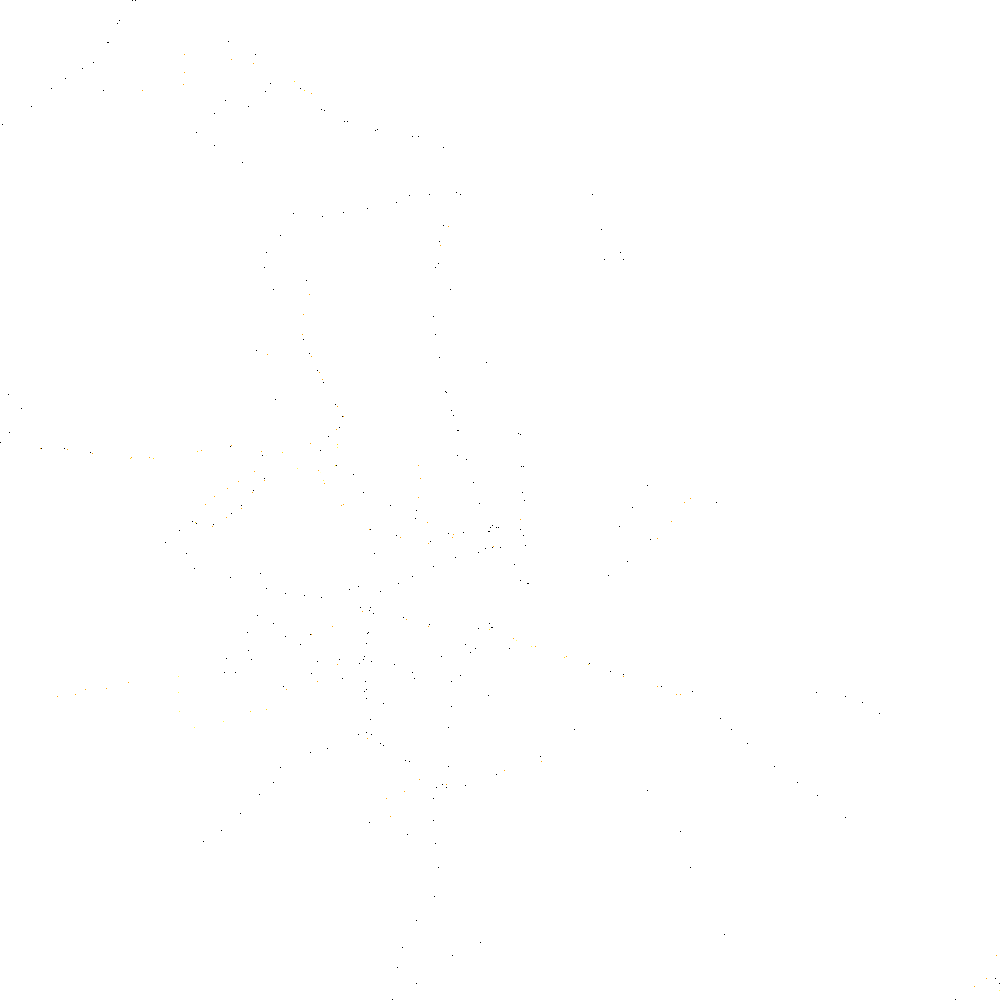

In [ ]:
#import pandas as pd
#!pip install plotly
import plotly.express as px
dff = geometry_df.query('y_coor < 47.548766').query('y_coor > 47.387982').query('x_coor > 18.954419').query('x_coor < 19.142015')
#bme_i = 47.47277215114886, 19.060034103922074
import plotly
#datashader steps
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(dff, x='x_coor', y='y_coor')
# agg is an xarray object, see http://xarray.pydata.org/en/stable/ for more details
coords_lat, coords_lon = agg.coords['y_coor'].values, agg.coords['x_coor'].values
# Corners of the image, which need to be passed to mapbox
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]

from colorcet import fire
import plotly.graph_objects as go
import datashader.transfer_functions as tf
img = tf.shade(agg, cmap=fire)[::-1].to_pil()

import plotly.express as px
# Trick to create rapidly a figure with mapbox axes
#fig = px.density_mapbox(geometry_df, lat=geometry_df.y_coor, lon= geometry_df.x_coor,zoom=12, hover_name='stop_name', 
#                        hover_data=["x_coor", "y_coor"], radius=5, labels={'get_on':'get_on', 'time_to_school':'time_to_school'})
fig = px.density_mapbox(geometry_df, lat = geometry_df.y_coor, lon = geometry_df.x_coor, z=geometry_df.z,
                        radius=20,
                        hover_name="stop_name",
                        hover_data=["x_coor","y_coor","time_to_school","vehicle"],
                        center = dict(lat = 47.47277215114886, lon = 19.060034103922074),
                        zoom = 12,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        )


#point to BME
fig.add_trace(go.Scattermapbox(
        lat=[47.47277215114886],
        lon=[19.060034103922074],
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(0, 144, 144)',
            opacity=0.7
        ),
        text=["BME I Epulet"],
    ) )
# Add the datashader image as a mapbox layer image
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

In [ ]:
anyád=trips[trips["trip_id"].isin(intercept_one["trip_id"])]
kurva=shapes[shapes["shape_id"].isin(anyád["shape_id"])]

In [ ]:
import shapely
lats = []
lons = []
names = []

for feature, name in zip(kurva.geometry, intercept_one["short_names"]):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        names = np.append(names, [name]*len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        names = np.append(names, None)

fig = px.line_mapbox(lat=lats, lon=lons, hover_name=names)

fig.add_trace(go.Scattermapbox(
        lat=[47.47277215114886],
        lon=[19.060034103922074],
        marker=go.scattermapbox.Marker(
            size=10,
            color='rgb(0, 144, 144)',
            opacity=0.7
        ),
        text=["BME I Epulet"],))

fig.update_layout(mapbox_style="carto-darkmatter",
                  mapbox_zoom=13,
                  margin={"r":0,"t":0,"l":0,"b":0}
                 )

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 308 (delta 79), reused 98 (delta 55), pack-reused 171
Receiving objects: 100% (308/308), 89.88 KiB | 8.17 MiB/s, done.
Resolving deltas: 100% (141/141), done.
Traceback (most recent call last):
  File "rapidsai-csp-utils/colab/env-check.py", line 1, in <module>
    import pynvml
ModuleNotFoundError: No module named 'pynvml'


In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:10 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu bionic InRelease [20.8 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/com

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...


In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.15.1
Uninstalling cffi-1.15.1:
  Successfully uninstalled cffi-1.15.1
Found existing installation: cryptography 37.0.4
Uninstalling cryptography-37.0.4:
  Successfully uninstalled cryptography-37.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.1/427.1 kB 22.6 MB/s eta 0:00:00
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(649): pinned spec python=3.8 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(649): pinned spec python=3.8 conflicts with explicit specs.  Overriding pinned spec.
failed